# Introduction

If you are a student in statistics or computer science, you may be fascinated by the elegance and effeciency of Jupyter Notebook. Meanwhile many of us would like to blogger using markdown in some static web blog framework like [Hexo](https://hexo.io/) and [Jekyll](https://jekyllrb.com/). **Why do not make notebook output files our everyday posts?** Sounds great, since we can record much more interesting things!

We know that thanks to [nbconvert](https://github.com/jupyter/nbconvert), an utility provided by [Jupyter community](https://github.com/jupyter) which can be used directy as a command line tool, we can convert `ipynb` files mainly into `html`, `tex`, `md(GFM)` and `PDF` format. Which choice should be the **fastest** one, given the situation where ipynb output is an embedded element in a blog post container? 

Well that is really hard to say since there have been already some solutions on the Web for different output formats, which you can refer to at the end of this post. However, not every solution is there for your needs and it is so hard to satisfy someone to the maximum extent that he or she is obliged to do some extra efforts to make his blog really a honey one, **JUST LIKE ME :)**

My choice: **Copy-paste md version directly into post**, for this is the most flexible and convenient way, highly compatible with the post container in terms of rendering style. Besides, its file size is much smaller than that of html output generated in *full* tempelate.

My problem: **GFM renderer of Hexo-Next theme is not friendly with math tex commands**, formulas often cannot be properly rendered by [Mathjax](https://www.mathjax.org/) because GFM renderer gets confused with some special symbols like `\\`, `\_` and `\[` between `\$\$` or `\$` pairs -- It does not know that characters between these two pairs are mathamatical formulas. Jupyter notebook markdown renderer deals pretty well with math formulas, so I do not want add manually escape characters one by one for blog posts!  

My solution: Inspired by [Hexo doc](https://hexo.io/docs/tag-plugins.html#Raw), I write [a tiny regular expression gist](rawEq.py) to automatically wrap math formulas with `raw` tag so that GFM renderer will not show interest in these guys.

Here is a notebook written in Jupyter and posted inside my blog. In other words,

$$What\ you \ see \buildrel \rm def \over {:=} A \ blog \ post \buildrel \rm generate \over \longleftarrow  A \ Jupyter \ Notebook$$.

# Conditional Expectation by Optimization

Now, let's consider the important case of the zero-mean bivariate Gaussian and try to find a function $h$ that minimizes the mean squared error (MSE). Again,  trying to solve for the conditional expectation by minimizing the error over all possible functions $h$ is generally very, very hard. One alternative is to use parameters for the $h$ function and then just optimize over those. For example, we could assume that $h(Y)= \alpha Y$ and then use calculus to find the $\alpha$ parameter.

Let's try this with the zero-mean bivariate Gaussian density,

$$\mathbb{E}((X-\alpha Y )^2) = \mathbb{E}(\alpha^2 Y^2 - 2 \alpha X Y + X^2 )$$

and then differentiate this with respect to $\alpha$ to obtain

$$\mathbb{E}(2 \alpha Y^2 - 2 X Y  ) = 2 \alpha \sigma_y^2 - 2 \mathbb{E}(XY) = 0$$

Then, solving for $\alpha$ gives us

$$\alpha = \frac{ \mathbb{E}(X Y)}{ \sigma_y^2 }$$

which means we have

$$\mathbb{ E}(X|Y) \approx \alpha Y = \frac{ \mathbb{E}(X Y )}{ \sigma_Y^2 } Y =\frac{\sigma_{X Y}}{ \sigma_Y^2 } Y$$

where that last equality is just notation. Remember here we assumed a special linear form for $h=\alpha Y$, but we did that for convenience. We still don't know whether or not this is the one true $h_{opt}$ that minimizes the MSE for all such functions.

# Conditional Expectation Using Direct Integration

Now, let's try this again by computing $\mathbb{E}(X|Y)$ in the case of the bivariate Gaussian distribution straight from the definition.

$$\mathbb{E}(X|Y)  = \int_{\mathbb{ R}} x \frac{f_{X,Y}(x,y)}{f_Y(y)} dx$$

where

$$ f_{X,Y}(x,y) = \frac{1}{2\pi |\mathbf{R}|^{\frac{1}{2}}} e^{-\frac{1}{2} \mathbf{v}^T \mathbf{R}^{-1} \mathbf{v} }$$ 

and where

$$\mathbf{v}= \left[ x,y \right]^T$$

$$\mathbf{R} = \left[\begin{array}{cc} \sigma_{x}^2 & \sigma_{xy}  \\\\   \sigma_{xy}  & \sigma_{y}^2 \\\\  \end{array} \right]$$ 

and with

$$\begin{eqnarray} \sigma_{xy} &=& \mathbb{E}(xy)   \nonumber    \\\\  \sigma_{x}^2 &=&  \mathbb{E}(x^2) \nonumber    \\\\  \sigma_{y}^2 &=& \mathbb{E}(y^2) \nonumber \end{eqnarray}$$

This conditional expectation (Eq. 4 above) is a tough integral to evaluate, so we'll do it with `sympy`.

In [35]:
from sympy import Matrix, Symbol, exp, pi, simplify, integrate 
from sympy import stats, sqrt, oo, use
from sympy.abc import y,x

sigma_x = Symbol('sigma_x',positive=True)
sigma_y = Symbol('sigma_y',positive=True)
sigma_xy = Symbol('sigma_xy',real=True)
fyy = stats.density(stats.Normal('y',0,sigma_y))(y)
 
R = Matrix([[sigma_x**2, sigma_xy],
            [sigma_xy,sigma_y**2]])
fxy = 1/(2*pi)/sqrt(R.det()) * exp((-Matrix([[x,y]])*R.inv()* Matrix([[x],[y]]))[0,0]/2 )

fcond = simplify(fxy/fyy)

Unfortunately, `sympy` cannot immediately integrate this without some hints. So, we need to define a positive variable ($u$) and substitute it into the integration

In [36]:
u=Symbol('u',positive=True) # define positive variable

fcond2=fcond.subs(sigma_x**2*sigma_y**2-sigma_xy**2,u) # substitute as hint to integrate
g=simplify(integrate(fcond2*x,(x,-oo,oo))) # evaluate integral
gg=g.subs( u,sigma_x**2 *sigma_y**2 - sigma_xy**2 ) # substitute back in
use( gg, simplify,level=2) # simplify exponent term

sigma_xy*y/sigma_y**2

Thus, by direct integration using `sympy`, we found

$$ \mathbb{ E}(X|Y) = Y \frac{\sigma_{xy}}{\sigma_{y}^{2}} $$ 

and this matches the prior result we obtained by direct minimization by assuming that $\mathbb{E}(X|Y) = \alpha Y$ and then solving for the optimal $\alpha$!

The importance of this result cannot be understated: the one true and optimal $h_{opt}$ *is a linear function* of $Y$. 

In other words, assuming a linear function, which made the direct search for an optimal $h(Y)$ merely convenient yields the optimal result! This is  a general result that extends for *all* Gaussian problems. The link between linear functions and optimal estimation of Gaussian random variables is the most fundamental result in statistical signal processing! This fact is exploited in everything from optimal filter design  to adaptive signal processing.

We can easily extend this result to non-zero mean problems by inserting the means in the right places as follows:

$$\mathbb{ E}(X|Y) = \bar{X} + (Y-\bar{Y}) \frac{\sigma_{xy}}{\sigma_{y}^{2}}$$

where $\bar{X}$ is the mean of $X$ (same for $Y$).

# Summary

In this section, we showed that the conditional expectation for Gaussian random variables is a linear function, which, by a bizarre coincidence, is also the easiest one to work with. This result is fundamental to all optimal linear filtering problems (e.g. Kalman filter) and is the basis of most of the theory of stochastic processes used in signal processing. Up to this point, we have worked hard to illustrate all of the concepts we will need to unify our understanding of this entire field and figured out multiple approaches to these kinds of problems, most of which are far more difficult to compute. Thus, it is indeed just plain lucky that the most powerful distribution is the easiest to compute as a conditional expectation because it is a linear function. We will come back to this same result again and again as we work our way through these greater concepts.

# 中文模式 

下面看看中英文混合的效果如何。

我们可以自由地写行内公式，如 $\cos 2\theta = \cos^2 \theta - \sin^2 \theta =  2 \cos^2 \theta - 1$。 We can display an inline formula, like $\sum_{i=0}^n i^2 = \frac{(n^2+n)(2n+1)}{6}$, very simple!

我们也可以写行间公式，如：

$$\frac{\partial u}{\partial t} = h^2 \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial z^2}\right)\qquad (1)$$

We can display formulas as blocks as followings:

$$
\left\{
\begin{aligned}
\dot{x} & = \sigma(y-x) \\[2ex]
\dot{y} & = \rho x - y - xz \\[2ex]
\dot{z} & = -\beta z + xy
\end{aligned}
\right.
\qquad (2)
$$

We can highlight equation by adding both border and background:

$$
\bbox[yellow,5px,border:2px solid red]
{
e^x=\lim_{n\to\infty} \left( 1+\frac{x}{n} \right)^n
\qquad (3)
}
$$

下面是一个矩阵：

$$
\begin{pmatrix}
1 & a_1 & a_1^2 & \cdots & a_1^n \\\
1 & a_2 & a_2^2 & \cdots & a_2^n \\\
\vdots & \vdots & \vdots & \ddots & \vdots \\\
1 & a_m & a_m^2 & \cdots & a_m^n \\\
\end{pmatrix}
$$

这是一个数组：

$$\begin{array}{c|lcr}value & \text{0} & \text{1} & \text{2} \\ \hline 0 & 0.24 & 1 & 125 \\ 1 & -1 & 189 & -8 \\ 2 & -20 & 2000 & 1+10i \end{array}$$

以下书写形式也很常用：

$$\operatorname*{Res}_{z=1}\left(\frac1{z^2-z}\right)=1\qquad (4)$$

$$\dbinom{n}{r}=\binom{n}{n-r}=C^n\_r=C^n\_{n-r}\qquad (5)$$

$$J_{\alpha}(x)=\sum\_{m=0}^{\infty}\frac{(-1)^{m}}{m!\Gamma(m+\alpha+1)}(\frac{x}{2})^{2m+\alpha}\qquad (6)$$

$$ i\hbar\frac{\partial \psi}{\partial t} = \frac{-\hbar^2}{2m} \left(\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + \frac{\partial^2}{\partial z^2} \right) \psi + V \psi \qquad (7)$$

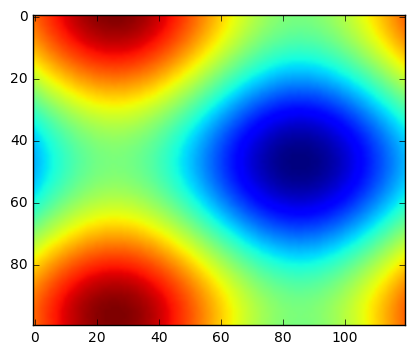

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

im = plt.imshow(f(x, y), animated=True)


def updatefig(*args):
    global x, y
    x += np.pi / 15.
    y += np.pi / 20.
    im.set_array(f(x, y))
    return im,

ani = animation.FuncAnimation(fig, updatefig, interval=50, blit=True)
plt.show()

[Add latex support to your hexo theme | Monk's Temple](http://www.pkumonk.me/2014/03/05/hexo-with-latex-support/)

[Nikola + nbconvert | Damian's blog](www.damian.oquanta.info/posts/nikola-nbconvert.html)

[@jakevdp uses Pelican and Jupyter Notebook to blog](http://jakevdp.github.io/)

[An IPython extension to clean, build and deploy your Nikola](https://www.youtube.com/watch?v=py21dq1ZW8s)

[HTML Imports: include for the web - HTML5 Rocks](https://www.html5rocks.com/en/tutorials/webcomponents/imports/)